In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data 
data = pd.read_excel('Online Retail.xlsx')
# Explore data
#data.head()
#data.info()
# 541 909 rows but 406 829 rows of Customer ID, so drop rows w/o Customer ID 

In [136]:
# Drop rows that have no Customer IDs associated with them
data = data.dropna(subset=['CustomerID'])
#data.info() 
# There are now 406 829 rows for all the columns

In [137]:
# RFM Segmentation (Behavioral customer segmentation based on three metrics)
# Feature engineering to carry out RF'M' analysis - Monetary (Create a new column 'Spend')

# Remove unnecessary rows (negative quantities indicate returns and Unit Price should not be 0!)
data = data[(data['Quantity'] > 1) & (data['UnitPrice'] != 0.0)]
#data.head()

# Create new variable
data['Spend'] = data['UnitPrice']* data['Quantity']
# data.head()

In [138]:
# Create an invoice month in order to do the cohort analysis on a month level
import datetime as dt
# Write function for month that takes a date as input (x) and returns a new datetime object representing the first day of the same month.
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
# apply the function
data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spend,InvoiceMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-12-01


In [139]:
# Testing to see why the tenure and recency were the same, yet frequency was unrealistically high (Repetition of the same InvoiceNo/InvoiceDate leading to exaggerated frequency numbers!)
data[data['CustomerID']==12349.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spend,InvoiceMonth
485502,577609,23112,PARISIENNE CURIO CABINET,2,2011-11-21 09:51:00,7.50,12349.0,Italy,15.00,2011-11-01
485503,577609,23460,SWEETHEART WALL TIDY,2,2011-11-21 09:51:00,9.95,12349.0,Italy,19.90,2011-11-01
485504,577609,21564,PINK HEART SHAPE LOVE BUCKET,6,2011-11-21 09:51:00,2.95,12349.0,Italy,17.70,2011-11-01
485505,577609,21411,GINGHAM HEART DOORSTOP RED,3,2011-11-21 09:51:00,4.25,12349.0,Italy,12.75,2011-11-01
485506,577609,21563,RED HEART SHAPE LOVE BUCKET,6,2011-11-21 09:51:00,2.95,12349.0,Italy,17.70,2011-11-01
...,...,...,...,...,...,...,...,...,...,...
485569,577609,21232,STRAWBERRY CERAMIC TRINKET POT,36,2011-11-21 09:51:00,1.25,12349.0,Italy,45.00,2011-11-01
485570,577609,22064,PINK DOUGHNUT TRINKET POT,12,2011-11-21 09:51:00,1.65,12349.0,Italy,19.80,2011-11-01
485571,577609,37448,CERAMIC CAKE DESIGN SPOTTED MUG,12,2011-11-21 09:51:00,1.49,12349.0,Italy,17.88,2011-11-01
485572,577609,37500,TEA TIME TEAPOT IN GIFT BOX,12,2011-11-21 09:51:00,4.95,12349.0,Italy,59.40,2011-11-01


In [140]:
# Check out the date range
print('Min: {}; Max: {}'.format(min(data.InvoiceMonth), max(data.InvoiceMonth)))

Min: 2010-12-01 00:00:00; Max: 2011-12-01 00:00:00


In [141]:
# Create hypothetical snapshot_date(which would be today in the real world) 
import datetime
snapshot_date = max(data.InvoiceMonth) + datetime.timedelta(days=1) 
snapshot_date

Timestamp('2011-12-02 00:00:00')

In [142]:
# Caluclate RFM Metrics as of today, as if I am running the analysis the day after the data was pulled

# Aggregate data on a customer level
datamart = data.groupby(['CustomerID']).agg({
    'InvoiceMonth': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique', # Changed it from count because count returned duplicates -- see commented out code block below on 'Tenure'
    'Spend': 'sum'})
# Rename columns for easier interpretation
datamart.rename(columns= {'InvoiceMonth': 'Recency',
                          'InvoiceNo': 'Frequency',
                          'Spend': 'MonetaryValue'}, inplace=True)
datamart.head(10)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,335,1,77183.60
12347.0,1,7,4310.00
12348.0,92,4,1677.24
12349.0,31,1,1392.35
12350.0,304,1,294.40
12352.0,31,7,1545.74
12353.0,215,1,89.00
12354.0,245,1,1002.65
12355.0,215,1,459.40


In [ ]:
# If you want to include Tenure in the analysis. Exposed an error with the Frequency calc.
# Calculate recency and tenure for each customer
# recency_df = data.groupby('CustomerID')['InvoiceMonth'].max()
# tenure_df = data.groupby('CustomerID')['InvoiceMonth'].min()

# Calculate the recency and tenure values for each customer in days
# recency = (snapshot_date - recency_df).dt.days
# tenure = (snapshot_date - tenure_df).dt.days

# Create a new DataFrame with the calculated recency and tenure
# datamart = pd.DataFrame({'Recency': recency, 'Tenure': tenure})

# Aggregate data on a customer level and rename columns
# datamart_agg = data.groupby('CustomerID').agg({
#     'InvoiceNo': 'nunique',  # Frequency
#     'Spend': 'sum'         # MonetaryValue
# }).rename(columns={'InvoiceNo': 'Frequency', 'Spend': 'MonetaryValue'})

# Combine the two DataFrames
# datamart = datamart.join(datamart_agg)

# Reset the index (optional)
#datamart.reset_index(inplace=True)
# datamart.head(10)


In [143]:
# Calculate the average Frequency
import numpy as np
np.mean(datamart['Frequency'])

4.2186272244049

### Customer Segmentation -- 1. Using RFM segments
RFM values can be grouped in several ways:
- Percentiles e.g. quantiles -- This project uses this
- Pareto 80/20 cut
- Custom-based on domain knowledge

In [144]:
# Building RFM Segments 1. Assign Quartiles of the 'R' Metric

# Recency quartile
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)
datamart.head()

,Recency,Frequency,MonetaryValue,R
CustomerID,,,,
12346.0,335,1,77183.60,1
12347.0,1,7,4310.00,4
12348.0,92,4,1677.24,2
12349.0,31,1,1392.35,4
12350.0,304,1,294.40,1


In [145]:
# Building RFM Segments 2. Assign Quartiles of the 'M' Metric

# Monetary value quartile
m_labels = range(1, 5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)
datamart.head()

,Recency,Frequency,MonetaryValue,R,M
CustomerID,,,,,
12346.0,335,1,77183.60,1,4
12347.0,1,7,4310.00,4,4
12348.0,92,4,1677.24,2,4
12349.0,31,1,1392.35,4,3
12350.0,304,1,294.40,1,2


In [146]:
# Building RFM Segments 3. Assign Quartiles of the 'F' Metric

# Frequency quartile
f_labels = range(1, 6)
f_quartiles, f_edges = pd.qcut(datamart['Frequency'], 4, labels=False, duplicates='drop', retbins=True)

# Generate bin labels based on bin edges
f_labels = [f_labels[q] for q in f_quartiles]

datamart = datamart.assign(F=f_labels)
datamart.head()

,Recency,Frequency,MonetaryValue,R,M,F
CustomerID,,,,,,
12346.0,335,1,77183.60,1,4,1
12347.0,1,7,4310.00,4,4,3
12348.0,92,4,1677.24,2,4,2
12349.0,31,1,1392.35,4,3,1
12350.0,304,1,294.40,1,2,1


In [147]:
# Build RFM Segments

# Concatenate RFM quartile values to RFM_Segment
def join_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
# Apply the function to the dataset across the columns
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart.head()

,Recency,Frequency,MonetaryValue,R,M,F,RFM_Segment
CustomerID,,,,,,,
12346.0,335,1,77183.60,1,4,1,114
12347.0,1,7,4310.00,4,4,3,434
12348.0,92,4,1677.24,2,4,2,224
12349.0,31,1,1392.35,4,3,1,413
12350.0,304,1,294.40,1,2,1,112


In [148]:
# Analysing RFM Table 
# .size() counts the number of occurrences of each unique 'RFM_Segment' value in the data.
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
434    589
111    463
423    306
112    296
411    243
412    224
212    186
211    176
424    160
311    143
dtype: int64

Observation: Both the highest and lowest RFM segments are among the largest ones. It's always best practice to investigate the size of the segments before using them for targeting or other business applications.

In [ ]:
# Filtering on RFM Segments
# filtered_data = datamart[datamart['RFM_Segment'] == '434']
# first_five_rows = filtered_data.head(5)
# print(first_five_rows)

### Customer Segmentation -- 2. Using RFM scores and creating bin-like customer segments which can also be labelled

Observation: Each of the RFM values are better with the higher RFM Score segment

In [150]:
# Create RFM Scores
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
datamart.head()

,Recency,Frequency,MonetaryValue,R,M,F,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,335,1,77183.60,1,4,1,114,6
12347.0,1,7,4310.00,4,4,3,434,11
12348.0,92,4,1677.24,2,4,2,224,8
12349.0,31,1,1392.35,4,3,1,413,8
12350.0,304,1,294.40,1,2,1,112,4


In [151]:
# Summary Statistics per RFM score
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           273.9       1.1         144.7   463
4           212.0       1.3         306.5   480
5           132.6       1.6         437.2   465
6            78.9       1.7         698.4   622
7            62.9       2.4         880.8   516
8            53.5       3.4        1177.4   404
9            37.1       4.3        1893.9   448
10           28.9       6.0        2423.3   340
11           16.4      14.9        8615.0   589

In [167]:
# Group into named segments/labels
def segment_me(df):
    if df['RFM_Score'] >= 11:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 11):
        return 'Silver'
    else:
        return 'Bronze'
datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
# Analyse the RFM values and group sizes across the 3 segments
datamart.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1).sort_values(by=[('MonetaryValue', 'mean'), ('Recency', 'mean')], ascending=[False, True])

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Gold               16.4      14.9        8615.0   589
Silver             68.4       3.0        1159.3  2795
Bronze            242.4       1.2         227.1   943

### Customer Segmentation -- 3. Using unsupervised learning with k-means Clustering
- Assumes that all variables have symmetrical distributions. This means the distributions are not skewed.
- Assumes equal variance and equal mean, so we will have to do a data pre-processing step.<br>

Preprocessing pipeline: 
1. unskew the data- log transformation
2. standardize to the same average value
3. scale to the same standard deviation
4. Store as a separate array to be used for clustering

In [153]:
# Check out the mean and variance of the RFM data
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4327.000000,4327.000000,4327.000000
mean,99.250058,4.218627,1971.006055
std,100.413684,7.427647,8881.606016
min,1.000000,1.000000,1.950000
25%,31.000000,1.000000,278.555000
50%,62.000000,2.000000,627.820000
75%,154.000000,5.000000,1583.585000
max,366.000000,197.000000,279678.290000


From the output above, both the means and averages are different between the three variables

In [154]:
# Check out original df
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,335,1,77183.60
12347.0,1,7,4310.00
12348.0,92,4,1677.24
12349.0,31,1,1392.35
12350.0,304,1,294.40


In [155]:
# Unskew the data
datamart_log = np.log(datamart_rfm)

# Normalize and Scale data using a scalar from scikit-learn library which returns an np array
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_log)

# Store for clustering
datamart_normalized = scaler.transform(datamart_log)
print(datamart_normalized[:10])

#Check the effect of the scaling and normalization
print('mean: ', datamart_normalized.mean(axis=0).round(2), 'std: ', datamart_normalized.std(axis=0).round(2))

[[ 1.19030852 -1.03925572  3.60430207]
 [-2.18446467  1.12547368  1.41945485]
 [ 0.44017727  0.50292862  0.70477365]
 [-0.19122976 -1.03925572  0.56380705]
 [ 1.13394583 -1.03925572 -0.61281058]
 [-0.19122976  1.12547368  0.64294681]
 [ 0.93288626 -1.03925572 -1.51870787]
 [ 1.00870387 -1.03925572  0.31516755]
 [ 0.93288626 -1.03925572 -0.27584922]
 [-0.19122976  0.18289645  1.09592497]]
mean:  [ 0. -0.  0.] std:  [1. 1. 1.]


In [156]:
# Implementing k-means clustering for 2 clusters

# Import package
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(datamart_normalized)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

# Analyzing average RFM values of each cluster
# Create a cluster label column in a new df using the original df
datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels)

# Calculate average RFM values to see the summary statistics of each cluster
datamart_rfm_k2.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(0)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          33.0       8.0        4432.0  1642
1         140.0       2.0         466.0  2685

### Choosing number of clusters using Elbow criterion visual method

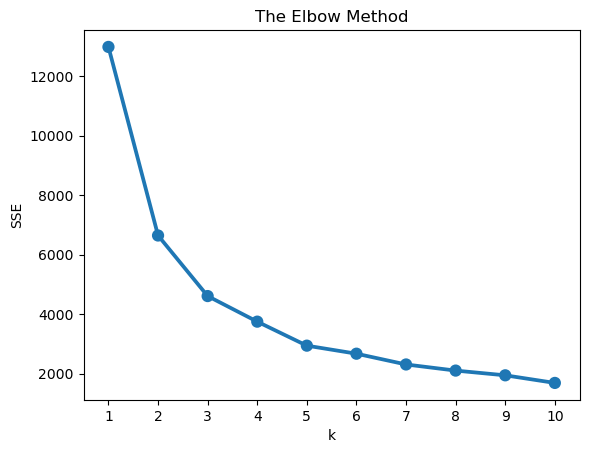

In [157]:
# Choosing number of clusters using the elbow criterion visual method
# # Implementing k-means clustering
# Import package
from sklearn.cluster import KMeans
# Fit KMeans and calculate SSE (sum of squared error) for each 'k'
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=26, n_init='auto')
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ # .inertia_ calculates the sse (sum of squared distance) to closest cluster center and the value at the kth iteration is stored 

# Plot SSE for each 'k'
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [158]:
 # Implementing k-means clustering for 4 clusters as seen from the elbow method
# Import package
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=26)

# Compute k-means clustering on pre-processed data
kmeans.fit(datamart_normalized)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

# Create a cluster label column in a new df using the original df
datamart_rfm_k4 = datamart_rfm.assign(Cluster = cluster_labels)

# Calculate average RFM values to see the summary statistics of each cluster
datamart_rfm_k4.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'sum', 'count']}).round(0).sort_values(by=('MonetaryValue','mean'), ascending=False)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency Frequency MonetaryValue                 
           mean      mean          mean        sum count
Cluster                                                 
2           1.0      11.0        6292.0  3737608.0   594
1          51.0       8.0        3954.0  3250135.0   822
3          95.0       3.0         862.0  1170374.0  1358
0         166.0       1.0         239.0   370426.0  1553

In [159]:
# Test: Checking cluster 2 to confirm Recency average of 1.0 above
datamart_rfm_k4[(datamart_rfm_k4['Recency']==1)& (datamart_rfm_k4['Cluster']==2)]

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,1,7,4310.00,2
12358.0,1,2,1168.06,2
12362.0,1,10,5118.78,2
12364.0,1,4,1283.10,2
12381.0,1,3,1756.56,2
...,...,...,...,...
18245.0,1,7,2516.66,2
18272.0,1,6,3078.58,2
18273.0,1,3,204.00,2


### Visualizing the relationships between RFM with scatter plots

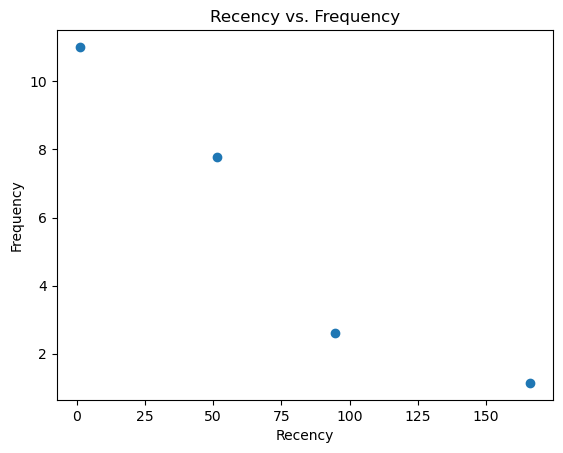

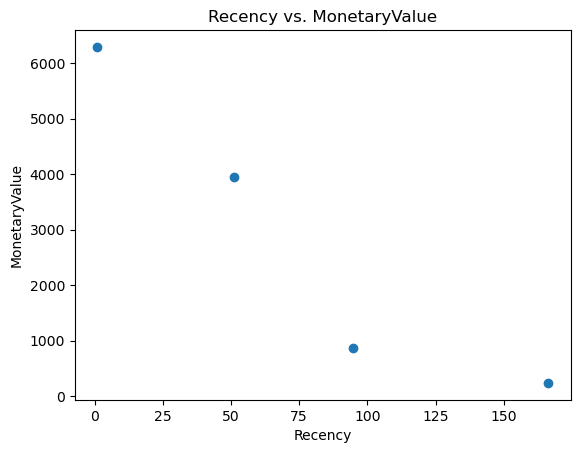

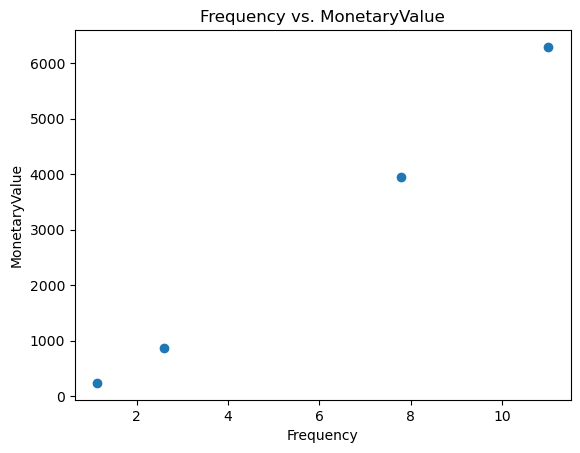

In [162]:
# Calculate average RFM values to see the summary statistics of each cluster
cluster_summary = datamart_rfm_k4.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).reset_index()  # Reset the index to convert the result back to a DataFrame

# Extract lists for R, F, and M
recency_list = cluster_summary['Recency'].tolist()
frequency_list = cluster_summary['Frequency'].tolist()
monetary_value_list = cluster_summary['MonetaryValue'].tolist()

plt.scatter(recency_list, frequency_list, marker='o')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency vs. Frequency')
plt.show()

plt.scatter(recency_list, monetary_value_list, marker='o')
plt.xlabel('Recency')
plt.ylabel('MonetaryValue')
plt.title('Recency vs. MonetaryValue')
plt.show()

plt.scatter(frequency_list, monetary_value_list, marker='o')
plt.xlabel('Frequency')
plt.ylabel('MonetaryValue')
plt.title('Frequency vs. MonetaryValue')
plt.show()

### Using a market research visualization technique (snake plots) to show segments and their RFM values on a line chart to aid with profiling and interpreting segments/clusters

<Axes: title={'center': 'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

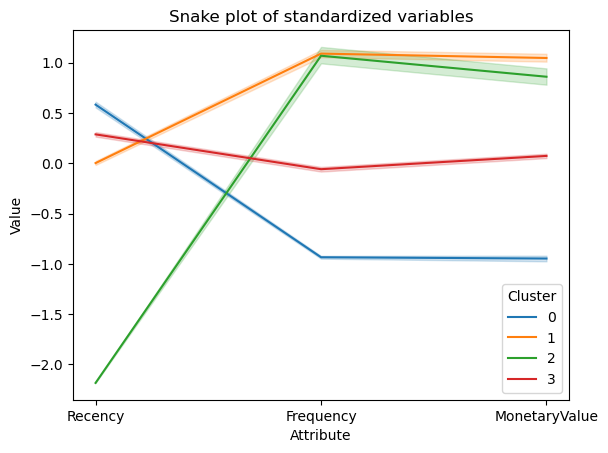

In [165]:
# Transform df from an np array to a pd df
datamart_normalized_df = pd.DataFrame(datamart_normalized, index=datamart_rfm.index,
columns=datamart_rfm.columns)
datamart_normalized_df['Cluster'] = datamart_rfm_k4['Cluster']
#datamart_normalized_df.describe()

# Melt data into long format, so RFM values and metric names are stored in one column each
datamart_melt = pd.melt(datamart_normalized_df.reset_index(),
id_vars=['CustomerID', 'Cluster'],
value_vars=['Recency', 'Frequency', 'MonetaryValue'],
var_name='Attribute',
value_name='Value')
datamart_melt.head()

# Visualize a snake plot

# Set the color palette with four distinct colors
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=datamart_melt, palette=custom_palette)
#plt.show()


### The snake plot -- understanding the relative importance of attributes within each cluster
The snake plot shows how much each attribute matters within each cluster. It helps us see which attributes are more or less important in defining a cluster's characteristics compared to others in the same cluster. Positive values mean an attribute is more important, and negative values mean it's less important. The plot allows us to identify the attributes that have the most impact on each cluster, i.e. the attributes that have the strongest influence on defining the unique characteristics of a particular customer cluster. These attributes play a significant role in determining why customers in that cluster are grouped together and how they behave. The snake plot helps us see which attributes are more dominant in shaping the identity of each cluster compared to others, making them more important in distinguishing one cluster from another.

Targeted Marketing Strategies: Identify the clusters with positive spikes on the snake plot for specific attributes. These clusters have higher-than-average values for those attributes, suggesting that customers with such characteristics are more representative of the cluster. You can recommend the marketing department to create targeted campaigns tailored to the preferences and needs of these specific customer segments.<br>

Customer Retention: Focus on the clusters with the highest positive spikes, as these attributes have a strong influence on the cluster's characteristics. Recommend implementing customer retention strategies that keep customers engaged and satisfied, leading to increased loyalty and repeat business.

### Relative importance of segment/cluster attributes to the population

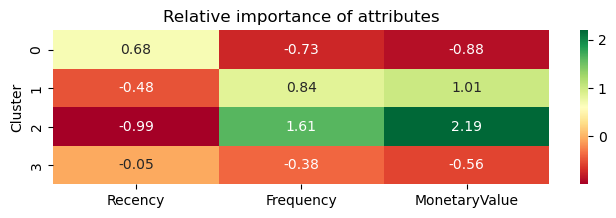

In [166]:
# Calculate average values of each cluster
cluster_avg = datamart_rfm_k4.groupby(['Cluster']).mean()
# Calculate average values of population
population_avg = datamart_rfm.mean()
# Calculate relative importance score of each of the RFM values of the segments/clusters
relative_imp = (cluster_avg / population_avg) -1

# Plot and analyze relative importance
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()